In [2]:
import numpy as np
import bayespy as bp
from bayespy import plot as bpplt
from matplotlib import pyplot as plt
from matplotlib import style
from matplotlib import cm
from matplotlib import dates as mdates
import scipy.stats
import scipy.io
import os
import json
from tqdm import tqdm_notebook
from glob import glob
import pandas as pd
from datetime import datetime, timedelta
import re
import multiprocessing
from time_series import *
import functools as ft
from matplotlib import rcParams
from matplotlib import ticker as mticker
from matplotlib import colors as mcolors

%matplotlib inline
style.use('../figures/scrartcl.mplstyle')

In [2]:
hyperparameters = os.environ.get('HYPERPARAMETERS')
if hyperparameters:
    with open(hyperparameters) as fp:
        hyperparameters = json.load(fp)
else:
    hyperparameters = {
        'rho/concentration': 1e-3,
        'Lambda/shape': 0.0,     # We will add on the dimensionality of the space
        'Lambda/scale': list(np.logspace(-2.5, -1, 25)),  # We will multiply by the identity matrix and the dimension
        'tau/shape': 1e-3,
        'tau/scale': 1e-3,
        'lambda/shape': 1e-5,
        'lambda/scale': 1e-5,
        'ard_prior': 'independent',
        'num_groups': 20,
        'num_factors': [8, 9, 10, 11, 12], # for ftse100 [4, 5, 6, 7, 8, 9],
        'seed': list(range(50)),
        'tolerance': 1e-6,
        'initialization': 'kmeans',
    }
    
print(json.dumps(hyperparameters, indent=4))

{
    "rho/concentration": 0.001,
    "Lambda/shape": 0.0,
    "Lambda/scale": [
        0.0031622776601683794,
        0.003651741272548377,
        0.004216965034285823,
        0.004869675251658631,
        0.005623413251903491,
        0.006493816315762113,
        0.007498942093324558,
        0.008659643233600654,
        0.01,
        0.011547819846894581,
        0.01333521432163324,
        0.01539926526059492,
        0.01778279410038923,
        0.02053525026457146,
        0.023713737056616554,
        0.027384196342643614,
        0.03162277660168379,
        0.03651741272548377,
        0.042169650342858224,
        0.04869675251658631,
        0.05623413251903491,
        0.06493816315762113,
        0.07498942093324558,
        0.08659643233600653,
        0.1
    ],
    "tau/shape": 0.001,
    "tau/scale": 0.001,
    "lambda/shape": 1e-05,
    "lambda/scale": 1e-05,
    "ard_prior": "independent",
    "num_groups": 20,
    "num_factors": [
        8,
        9,
       

# Load the data

In [5]:
DATA = os.environ.get('DATA', 'yahoo_sp100')

read_csv_kwargs = {
    'header': None, 
    'index_col': None,
    'parse_dates': ['date']
}
start = datetime(2016, 1, 1)
end = datetime(2017, 1, 1)
exclude = []

log_returns = None

if DATA in ('yahoo_sp100', 'quantquote_sp500'):
    if DATA == 'yahoo_sp100':
        # Load data obtained from yahoo finance
        filenames = glob('../data/yahoo_sp100/*.csv')
        read_csv_kwargs.update({
            'names': ['date', 'open', 'high', 'low', 'unadjusted', 'close', 'volume'],
            'skiprows': 1,
            'na_values': 'null',
        })

        exclude.extend([
            'foxa',  # FOX is the ticker with voting rights
            'goog',  # GOOGL is the ticker with voting rights
        ])

    elif DATA == 'quantquote_sp500':
        # Load the data from https://quantquote.com/historical-stock-data
        # Docs are similar to https://quantquote.com/docs/QuantQuote_Minute.pdf
        filenames = glob('../data/quantquote_sp500/table_*.csv')
        read_csv_kwargs['names'] = ['date', 'time', 'open', 'high', 'low', 'close', 'volume']
        
    closing = {}
    for filename in tqdm_notebook(filenames):
        symbol = re.search(r'([a-zA-z\.]+)\.csv', filename).group(1).lower()
        if symbol in exclude:
            print('excluding %s' % symbol)
        else:
            data = pd.read_csv(filename, **read_csv_kwargs)
            closing[symbol] = data.set_index('date').close.astype(float)

    closing = pd.DataFrame(closing)
    symbols = np.asarray(closing.columns)

    # Make manual adjustments
    if DATA == 'yahoo_sp100':
        # On 2012-10-01 Kraft foods (KFT) changed its name to Mondelez (MDLZ) and retired
        # its ticker. It also spun off Kraft foods (KRFT) such that 
        # 1 KFT = 1 MDLZ + 1/3 KRFT
        # See http://www.mondelezinternational.com/investors/stock-information/spin-off-information 
        # for details. Yahoo considers the price of the stock and does not 
        # account for the spin-off which we do manually.
        closing['mdlz'] *= np.where(closing.index < datetime(2012, 10, 2), 1, 4 / 3)

        # On 2016-08-05, BMY shares dropped due to a failed cancer treatment trial 
        # (http://fortune.com/2016/08/05/bristol-myers-tanks-opdivo/)

        # On 2015-07-24, BIIB shares dropped due to poor quarterly performance and bad data
        # on an Alzheimer drug
        # (https://www.fool.com/investing/general/2015/08/05/heres-why-biogen-lost-20-billion-in-market-value-i.aspx)
        
    names = pd.read_csv('../data/symbol_map_comnam.csv', skiprows=4, header=None, 
                    names=['symbol', 'permno', 'name'], encoding='latin1')
    names = {key: value for key, value in zip(names.symbol, names.name)}

    missing = symbols[~np.in1d(symbols, list(names))]
    assert not missing.size, "missing names: %s" % ", ".join(missing)
    
elif DATA == 'multiasset':
    data = scipy.io.loadmat('../data/multi_asset_data.mat')
    dates = np.squeeze(mdates.num2date(data['dates']))
    columns = [row[0] for row in np.squeeze(data['tickers'])]
    log_returns = pd.DataFrame(np.log(1 + data['returns']), dates, columns)
elif DATA == 'ftse100':
    closing = pd.read_csv('../data/frapo/FTSE100.csv', index_col=0, parse_dates=[0])
    del closing['SDRC.L']  # Non-voting shares of SDR.L
else:
    raise KeyError(DATA)
    
if log_returns is None:
    log_returns = (np.log(closing) - np.log(closing.shift(1))).dropna(how='all')
    
# Manually correct data
if DATA == 'ftse100':
    # Unilever performed a reverse stock split (http://www.wikinvest.com/stock/Unilever_(UL)/Existing_Unilever_Plc_Ordinary_Shares_Pence_Each_New)
    log_returns.loc[datetime(2006, 5, 22), 'ULVR.L'] = np.nan
    # Shell had a merger (http://www.ft.com/cms/s/0/af3dc0d2-e771-11d9-a721-00000e2511c8.html?ft_site=falcon&desktop=true#axzz4rX5QXHxs)
    log_returns.loc[datetime(2005, 7, 18), 'RDSB.L'] = np.nan
    # British Energy had a restructure (https://www.nao.org.uk/report/the-restructuring-of-british-energy/)
    log_returns.loc[datetime(2005, 1, 17), 'BGY.L'] = np.nan
    # Bonus issue of Antofagsta (http://www.moneyam.com/InvestorsRoom/posts.php?tid=9826&from=7)
    log_returns.loc[datetime(2006, 6, 19), 'ANTO.L'] = np.nan
    # Resolution limited apparently before its incorporation?
    log_returns.loc[datetime(2003, 11, 3), 'RSL.L'] = np.nan
    # Subdivision of shares of Enterprise Inns happened around this time (http://www.eigroupplc.com/content/dam/enterprise-inns/corporate/investors/reports/interim-report-2007.pdf.downloadasset.pdf)
    log_returns.loc[datetime(2007, 1, 15), 'ETI.L'] = np.nan
    # Another subdivision (http://www.annualreports.com/HostedData/AnnualReportArchive/e/LSE_ETI_2004.pdf)
    log_returns.loc[datetime(2004, 1, 19), 'ETI.L'] = np.nan
    # Poor result of Morrison's appears to be genuine (http://news.bbc.co.uk/1/hi/business/3859191.stm)
    # Great results of Cairn Energy are genuine (https://www.theguardian.com/business/2004/jan/19/oilandpetrol.money)
    # There appears to be a stock split in Cairn Energy in 2007 (https://uk.finance.yahoo.com/chart/CNE.L#eyJzaG93QXJlYSI6ZmFsc2UsIm11bHRpQ29sb3JMaW5lIjpmYWxzZSwiYm9sbGluZ2VyVXBwZXJDb2xvciI6IiNlMjAwODEiLCJib2xsaW5nZXJMb3dlckNvbG9yIjoiIzk1NTJmZiIsIm1maUxpbmVDb2xvciI6IiM0NWUzZmYiLCJtYWNkRGl2ZXJnZW5jZUNvbG9yIjoiI2ZmN2IxMiIsIm1hY2RNYWNkQ29sb3IiOiIjNzg3ZDgyIiwibWFjZFNpZ25hbENvbG9yIjoiIzAwMDAwMCIsInJzaUxpbmVDb2xvciI6IiNmZmI3MDAiLCJzdG9jaEtMaW5lQ29sb3IiOiIjZmZiNzAwIiwic3RvY2hETGluZUNvbG9yIjoiIzQ1ZTNmZiIsImxpbmVUeXBlIjoibGluZSIsInJhbmdlIjoibWF4In0%3D)
    log_returns.loc[datetime(2007, 3, 26), 'CNE.L'] = np.nan
    
    # Looks like a data error in morrisons (consecutive rise and fall)
    log_returns.loc[datetime(2004, 7, 5), 'MRW.L'] = np.nan
    log_returns.loc[datetime(2004, 7, 12), 'MRW.L'] = np.nan
    
    # Acquisition of MIM Holdings by XStrata
    log_returns.loc[datetime(2003, 5, 5), 'XTA.L'] = np.nan
    
    # Reverse stock split by Smiths Group (https://www.smiths.com/siteFiles/resources/featureAttachments/ApportionmentofBaseCostofOldOrdinaryShares.pdf)
    log_returns.loc[datetime(2007, 6, 18), 'SMIN.L'] = np.nan
    
    # New shares being issued for Hammerson (https://www.hammerson.com/media/press-releases/application-for-a-block-listing/)
    log_returns.loc[datetime(2007, 10, 29), 'HMSO.L'] = np.nan
    
    # The odd behaviour of OML is not reproduced by Google finance
    log_returns.loc[datetime(2004, 4, 19), 'OML.L'] = np.nan
    
    # Reverse merger of Severn Trent (https://www.severntrent.com/investors/share-capital-history/demerger-of-biffa-plc/)
    log_returns.loc[datetime(2006, 10, 9), 'SVT.L'] = np.nan
    
    # Restructuring of 3i (http://www.3i.com/site-services/faqs/shareholders-info)
    log_returns.loc[datetime(2007, 7, 16), 'III.L'] = np.nan
    
    # Weird behaviour of british energy before its relisting
    log_returns.loc[:datetime(2005, 1, 17), 'BGY.L'] = np.nan
    

excluding foxa
excluding goog



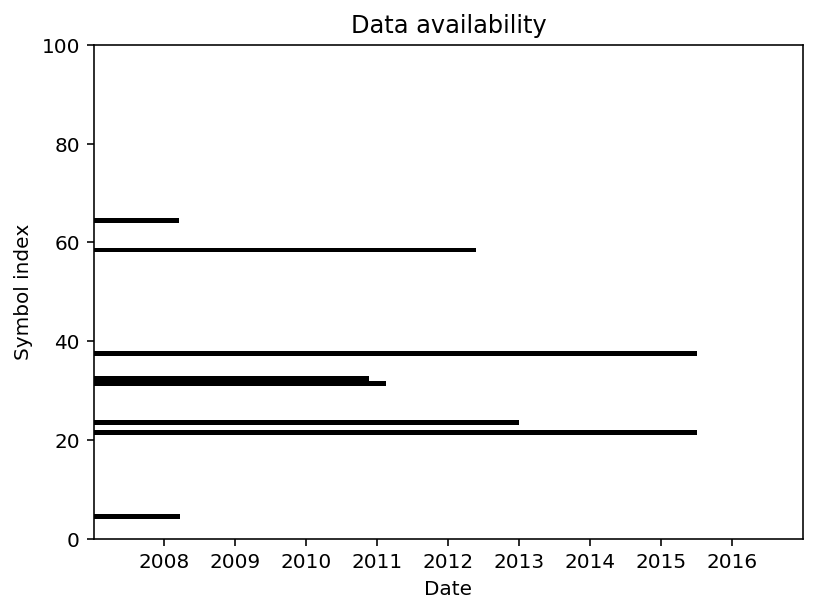

In [6]:
fig, ax = plt.subplots(1, 1)

extent = [mdates.date2num(min(log_returns.index)), mdates.date2num(max(log_returns.index)), 
          0, log_returns.shape[1]]
ax.imshow(~pd.isnull(log_returns).T, aspect='auto', extent=extent, cmap='binary_r', vmin=0, vmax=1)
ax.xaxis_date()
ax.set_ylabel('Symbol index')
ax.set_xlabel('Date')
ax.set_title('Data availability')
fig.tight_layout()

bmy 9.192271800851895 2016-08-05 00:00:00
cvs 8.908314982050705 2016-11-08 00:00:00
axp 8.223416727519298 2016-01-22 00:00:00
fb 8.210235252513419 2016-01-28 00:00:00
mrk 7.536182808592935 2016-08-05 00:00:00
wmt 7.5340058377468795 2016-05-19 00:00:00
agn 7.404370967236589 2016-04-05 00:00:00
fdx 7.273483085934512 2016-03-17 00:00:00
mdt 7.242094337072899 2016-11-22 00:00:00
lly 7.192191910985922 2016-11-23 00:00:00
hon 6.9462551968134605 2016-10-07 00:00:00
csco 6.705780259166224 2016-02-11 00:00:00


/Users/till/.local/share/virtualenvs/time_series-E7pjRGdR/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


(252, 100)

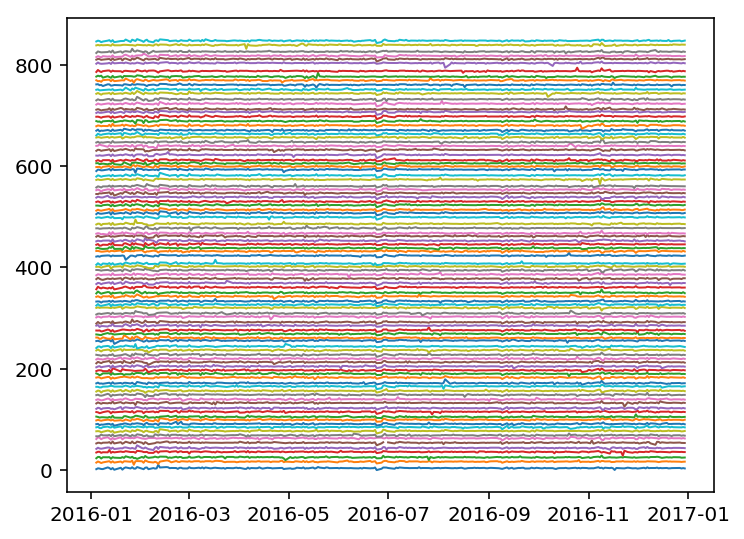

In [7]:
# Restrict the input and normalise the returns to unit variance
nlr = log_returns if start is None else log_returns[log_returns.index >= start]
nlr = (nlr if end is None else nlr[nlr.index < end]) # .dropna('columns', 'any')    
scale = nlr.std()
nlr = (nlr - nlr.mean()) / scale

fig, ax = plt.subplots()
offset = 0
for symbol in nlr:
    x = nlr[symbol]
    offset -= x.min()
    ax.plot(offset + x)
    offset += x.max()

absolute_returns = nlr.abs().max().sort_values(ascending=False)
for i, (symbol, max_nlr) in enumerate(absolute_returns.items()):
    print(symbol, max_nlr, np.argmax(np.abs(nlr[symbol]) == max_nlr))
    if i > 10:
        break
        
y = nlr.values
y.shape

In [6]:
variables, list_params = build_parameters(hyperparameters, 'num_factors', 'seed')

def target(hyperparameters):
    np.random.seed(hyperparameters['seed'])
    Q = latent_factor_model(y, hyperparameters)
    Q.update(repeat=None, verbose=False, tol=hyperparameters['tolerance'])
    return Q

with multiprocessing.Pool() as pool:
    models = list(tqdm_notebook(pool.imap(target, list_params), total=len(list_params)))

HBox(children=(IntProgress(value=0, max=250), HTML(value='')))

In [7]:
shape = [len(x) for x in variables.values()]
lowerbounds = np.reshape([Q.compute_lowerbound() for Q in models], shape)

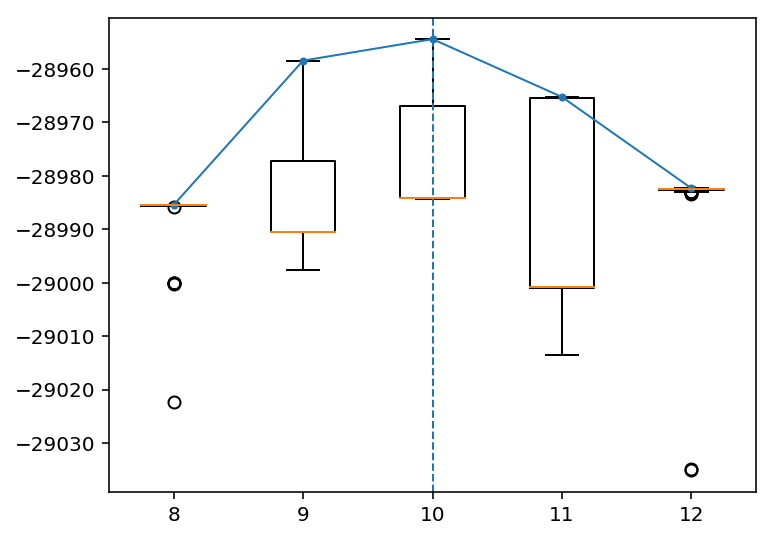

In [8]:
plt.boxplot(np.transpose(lowerbounds), positions=variables['num_factors'])
plt.plot(variables['num_factors'], np.max(lowerbounds, axis=1), marker='.', color='C0')
best_num_factors = variables['num_factors'][np.argmax(np.max(lowerbounds, axis=1))]
plt.axvline(best_num_factors, ls='--')

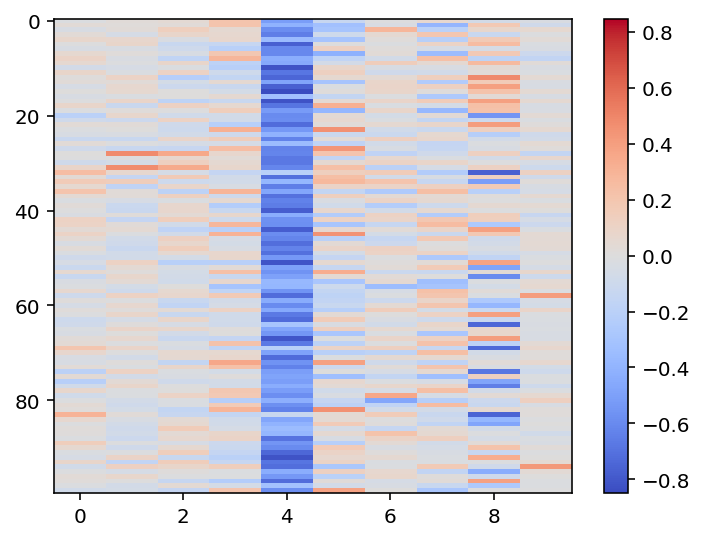

In [9]:
Q = max(models, key=lambda x: x.compute_lowerbound())
A = np.squeeze(Q['A'].get_moments()[0])
vmax = np.abs(A).max()
plt.imshow(A, aspect='auto', vmax=vmax, vmin=-vmax, cmap='coolwarm')
plt.colorbar()

In [10]:
Q['x'].get_moments()[0].std(axis=0)

array([[ 0.85217198,  0.9125456 ,  0.91342067,  0.93814568,  0.99519167,
         0.95650875,  0.89167031,  0.93529818,  0.98427365,  0.88289634]])

In [11]:
variables2, list_params2 = build_parameters(hyperparameters, 'Lambda/scale', 'seed', num_factors=best_num_factors)

with multiprocessing.Pool() as pool:
    models2 = list(tqdm_notebook(pool.imap(
        ft.partial(fit_model, y, A=A, steps=(0, 1, 2, 3, 4)), list_params2
    ), total=len(list_params2)))

HBox(children=(IntProgress(value=0, max=1250), HTML(value='')))

In [12]:
shape2 = [len(x) for x in variables2.values()]
lowerbounds2 = np.reshape([Q.compute_lowerbound() for Q in models2], shape2)
num_groups = np.reshape([len(set(np.argmax(Q['z'].get_moments()[0], axis=1))) for Q in models2], shape2)
am = np.argmax(lowerbounds2, axis=1)
best_num_groups = num_groups[np.arange(shape2[0]), am]
best_models = np.asarray(models2).reshape(shape2)[np.arange(shape2[0]), am]

Q = max(models2, key=lambda x: x.compute_lowerbound())

In [13]:
from scipy.spatial.distance import cdist
from sklearn import metrics

In [14]:
labels = np.asarray([np.argmax(_Q['z'].get_moments()[0], axis=1) for _Q in best_models])
nmis = cdist(labels, labels, metrics.normalized_mutual_info_score)

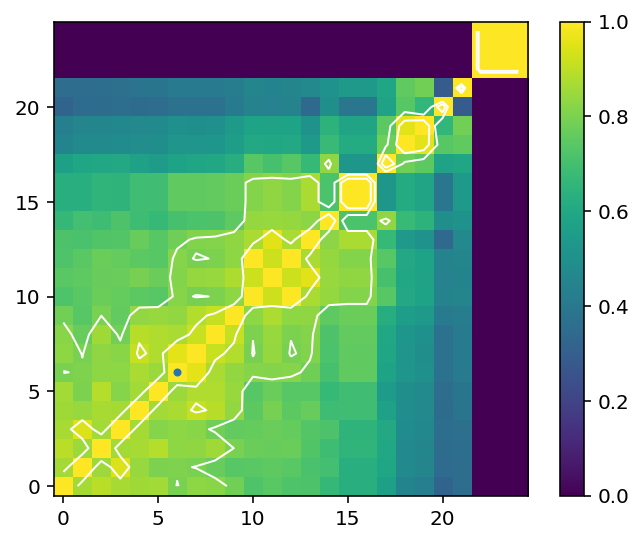

In [15]:
plt.imshow(nmis, origin='lower', vmin=0, vmax=1)
plt.colorbar()
plt.contour(nmis, levels=[0.8, 0.9], colors='w')
i = np.argmax(np.max(lowerbounds2, axis=1))
plt.scatter(i, i)

In [16]:
class CustomScalarFormatter(mticker.ScalarFormatter):
    def __init__(self, useOffset=None, useMathText=None, useLocale=None, data_format=None):
        super(CustomScalarFormatter, self).__init__(useOffset, useMathText, useLocale)
        self.data_format = data_format or '%.1f'
    
    def format_data(self, value):
        if self._useLocale:
            s = locale.format_string(self.data_format, (value,))
        else:
            s = self.data_format % value
        s = self._formatSciNotation(s)
        return self.fix_minus(s)

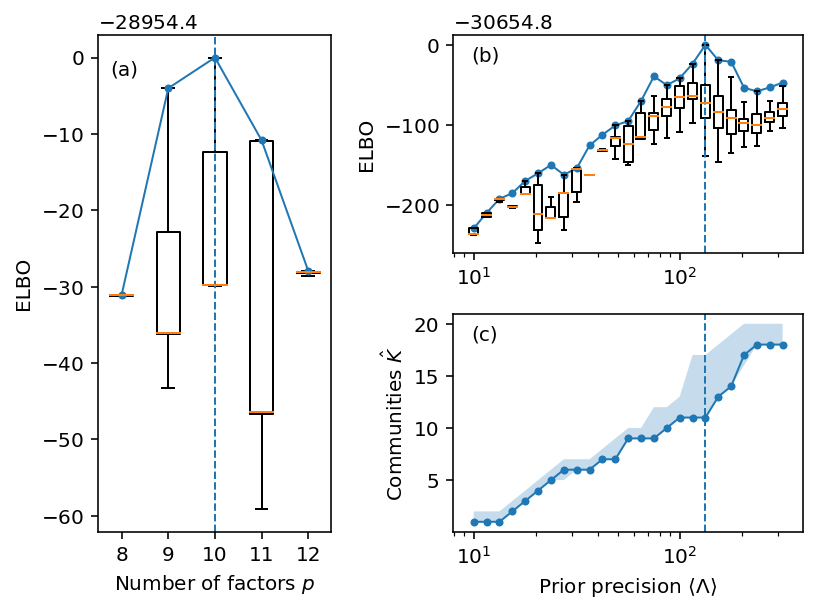

In [37]:
from matplotlib import gridspec

fig = plt.figure()
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 3])
ax1 = plt.subplot(gs[:, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1, 1], sharex=ax2)

ax1.boxplot(np.transpose(lowerbounds), positions=variables['num_factors'], showfliers=False)
ax1.plot(variables['num_factors'], np.max(lowerbounds, axis=1), marker='.', color='C0')
best_num_factors = variables['num_factors'][np.argmax(np.max(lowerbounds, axis=1))]
ax1.axvline(best_num_factors, ls='--')

scale = np.asarray(variables2['Lambda/scale'])
prior_precision = 1 / scale
best_lowerbounds2 = np.max(lowerbounds2, axis=1)
ax2.plot(prior_precision, best_lowerbounds2, marker='.')
ax2.set_xscale('log')
ax2.boxplot(lowerbounds2.T, positions=prior_precision, widths=0.1 * prior_precision,
            manage_xticks=False, showfliers=False)

ax3.plot(prior_precision, best_num_groups, marker='.')
ax3.fill_between(prior_precision, np.min(num_groups, axis=1), np.max(num_groups, axis=1), alpha=.25)

for ax in (ax2, ax3):
    ax.axvline(prior_precision[np.argmax(best_lowerbounds2)], ls='--')

# for ax in (ax1, ax2):
# ax1.yaxis.set_major_locator(mticker.MaxNLocator(4))
ax1.yaxis.set_major_formatter(CustomScalarFormatter(np.max(lowerbounds), True))
ax1.yaxis.set_ticks(np.max(lowerbounds) - 10 * np.arange(7))

ax2.yaxis.set_major_formatter(CustomScalarFormatter(np.max(lowerbounds2), True))
ax2.yaxis.set_ticks(np.max(lowerbounds2) - 100 * np.arange(3))
    
label_axes((ax1, ax2, ax3))

ax1.set_xlabel('Number of factors $p$')
ax1.set_ylabel('ELBO')
ax2.set_ylabel('ELBO')
ax3.set_xlabel(r'Prior precision $\left\langle \Lambda\right\rangle$')
ax3.set_ylabel(r'Communities $\hat K$')
    
fig.tight_layout()
fig.savefig('../figures/sp100-sweep.png')
fig.savefig('../figures/sp100-sweep.pdf')

In [18]:
_Qs = np.reshape(models2, shape2)[np.argmax(best_lowerbounds2)]
labels = np.asarray([np.argmax(_Q['z'].get_moments()[0], axis=1) for _Q in _Qs])
nmis = cdist(labels, labels, metrics.normalized_mutual_info_score)

/Users/till/miniconda3/envs/time_series/lib/python3.6/site-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


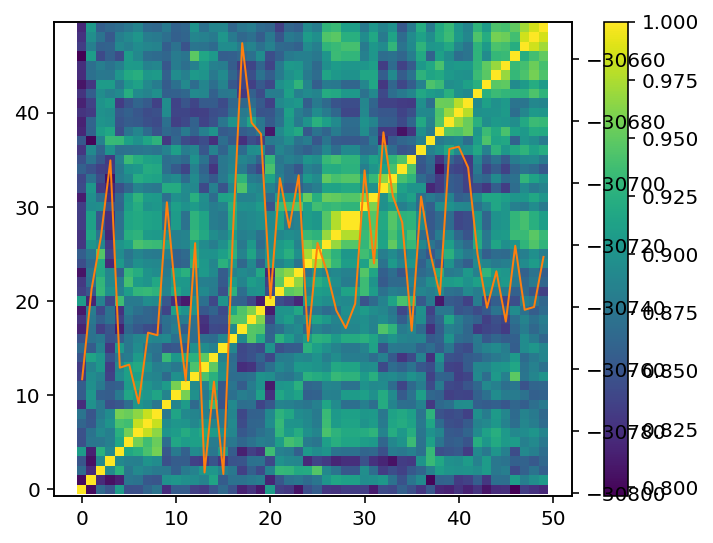

In [19]:
linkage = scipy.cluster.hierarchy.linkage(1 - nmis)
dendrogram = scipy.cluster.hierarchy.dendrogram(linkage, no_plot=True)
leaves = dendrogram['leaves']

plt.imshow(nmis[leaves][:, leaves], origin='lower', vmax=1)
plt.colorbar()
plt.twinx()
plt.plot(np.reshape(lowerbounds2, shape2)[np.argmax(best_lowerbounds2)][leaves], color='C1')

87.5 0 25
66.5 25 42
52.0 42 54
37.5 54 71
25.0 71 79
17.5 79 86
13.0 86 88
10.5 88 91
7.0 91 95
4.0 95 97


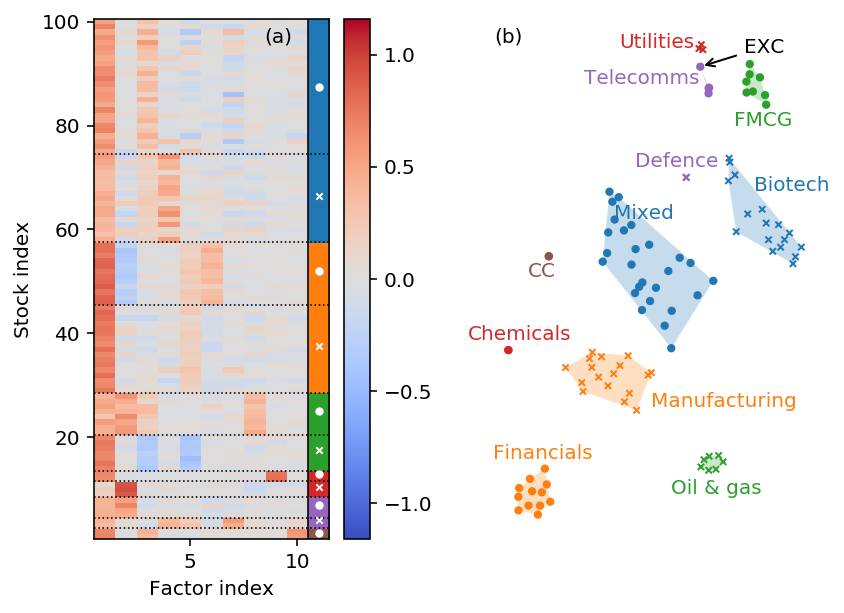

In [57]:
cmap = mcolors.ListedColormap(['C0', 'C1', 'C2', 'C3', 'C4', 'C5'])
np.random.seed(3)

fig, (ax1, ax2) = plt.subplots(1, 2) #, gridspec_kw={'width_ratios': [3, 4]})

mds = sklearn.manifold.TSNE(perplexity=20, learning_rate=10, n_iter=5000)  # Great
# mds = sklearn.manifold.MDS()  # Good
# mds = sklearn.manifold.Isomap()  # Meh
# mds = sklearn.manifold.SpectralEmbedding()  # Bad
# mds = sklearn.manifold.LocallyLinearEmbedding()  # Terrible

_A = Q['A'].get_moments()[0].copy()
_z = Q['z'].get_moments()[0]
# i = get_best_permutation(_A, _z)
mds.fit(_A)
labels = relabel(np.argmax(_z, axis=1))
i = np.argsort(labels)

vmax = np.max(np.abs(vmax))
j = np.argsort(np.sum(_A ** 2, axis=0))[::-1]
extent = (.5, _A.shape[1] + .5, .5, _A.shape[0] + .5)
_A *= np.where(np.mean(_A, axis=0) < 0, -1, 1)
m = ax1.imshow(_A[i][:, j], aspect='auto', cmap='coolwarm',
               vmax=vmax, vmin=-vmax, extent=extent)
cb = plt.colorbar(m, ax=ax1)
# cb.set_label('Factor loadings $A$')

# Draw lines
lw = rcParams['axes.linewidth']
for j in np.where(labels[i][1:] != labels[i][:-1])[0]:
    ax1.axhline(100 - (j + .5), ls=':', color='k', lw=lw)
    
previous = 0
circle = True
kwargs = {'color': 'w', 's': 10, 'zorder': 999}
for j in np.where(labels[i][1:] != labels[i][:-1])[0]:
    _y = 100 - (previous + j) / 2
    print(_y, previous, j)
    ax1.scatter(11, _y, marker = 'o' if circle else 'x', **kwargs)
    previous = j
    circle = not circle
ax1.scatter(11, 100 - (previous + 100) / 2, marker = 'o' if circle else 'x', **kwargs)
    
    
ax1.axvline(A.shape[1] + 0.5, color='k', lw=lw)
extent = (_A.shape[1] + 0.5, _A.shape[1] + 1.5, 0.5, 0.5 + _A.shape[0])
ax1.imshow(labels[i, None], extent=extent, aspect='auto', cmap=cmap, vmax=11)

ax1.set_xlabel('Factor index')
ax1.set_ylabel('Stock index')
ax1.set_xlim(0.5, A.shape[1] + 1.5)

step = -1

parity = (1, -1)
kwargs = dict(cmap=cmap, clip_on=False, vmax=11, s=10)
embedding = mds.embedding_[:, ::step] * parity
ax2.scatter(*embedding[labels % 2 == 0].T, c=labels[labels % 2 == 0], **kwargs, marker='o')
ax2.scatter(*embedding[labels % 2 == 1].T, c=labels[labels % 2 == 1], **kwargs, marker='x')


ax2.set_aspect(1)
ax2.set_axis_off()
ax2.autoscale(tight=True)

if True:
    for symbol, xytext in [('exc', (.8, .98))]:
        i = list(log_returns.columns).index(symbol)
        ax2.annotate(
            symbol.upper(),
            xy=embedding[i],
            xytext=xytext,
            textcoords='axes fraction',
            arrowprops={'arrowstyle': '->'}
        )
        
if False:
    for symbol in ['exc']:
        i = list(log_returns.columns).index(symbol)
        ax2.text(*(embedding[i]), symbol.upper())

communities = {
    0: ('Mixed', (-1.5, 2.25)),
    1: ('Biotech', (-.5, 1.5)),
    2: ('Financials', (-2, 1.75)),
    3: ('Manufacturing', (2, -1.5)),
    4: ('FMCG', (-1, -2)),
    5: ('Oil & gas', (-2, -1.5)),
    6: ('Chemicals', (-2, .5)),
    7: ('Utilities', (-4, 0)),
    8: ('Telecomms', (-6, 0)),
    9: ('Defence', (-2.5, .5)),
    10: ('CC', (-1, -1)),
}
        
for i in np.unique(labels):
    color = cmap.colors[i // 2]
    _x = embedding[labels == i]
    if i in communities:
        label, delta = communities[i]
        ax2.text(*(_x.mean(axis=0) + delta), label, color=color)
    if len(_x) > 2:
        hull = scipy.spatial.ConvexHull(_x)
        p = mpatches.Polygon(hull.points[hull.vertices], facecolor=color, alpha=.25)
        ax2.add_artist(p)

fig.text(0.325, 0.92, '(a)')
fig.text(0.6, 0.92, '(b)')

fig.tight_layout()
fig.savefig('../figures/sp100-factor-loadings.pdf')
fig.savefig('../figures/sp100-factor-loadings.png')

In [58]:
with open('../data/names.json') as fp:
    names = json.load(fp)

In [59]:
df = pd.DataFrame(list(zip(symbols, labels, [names[s] for s in symbols])), columns=['symbol', 'label', 'name'])
group = 1
for _, subset in df.groupby('label'):
    # print(subset)
    ncols = 3
    parts = ["%s (%s)" % (tup.name.replace('&', '\\&'), tup.symbol.upper()) for tup in subset.itertuples()]
    final = []
    for i, part in enumerate(parts):
        final.append(part)
        if i == len(parts) - 1:
            final.append('\\\\\\hline\n')
        elif i > 0 and i % ncols == 0:
            final.append('\\\\\n')
        else:
            final.append('&')

    print(str(group) + ' & ' + ', '.join(parts) + r'\\')
    group += 1

1 & Apple (AAPL), Abbott Laboratories (ABT), Accenture (ACN), Amazon (AMZN), American Express (AXP), Cisco (CSCO), Danaher (DHR), Walt Disney (DIS), Facebook (FB), Twenty-First Century Fox (FOX), Google (GOOGL), Home Depot (HD), Intel (INTC), Lowe's (LOW), Medtronic (MDT), Monsanto (MON), Microsoft (MSFT), Nike (NKE), Oracle (ORCL), Priceline.com (PCLN), Paypal (PYPL), Qualcomm (QCOM), Starbucks (SBUX), Time Warner (TWX), Texas Instruments (TXN), Walgreen (WBA)\\
2 & AbbVie (ABBV), Actavis (AGN), Amgen (AMGN), Biogen (BIIB), Bristol-Myers Squibb (BMY), Celgene (CELG), Costco (COST), CVS (CVS), Gilead (GILD), Johnson \& Johnson (JNJ), Eli Lilly (LLY), McDonald's (MCD), Merck (MRK), Pfizer (PFE), Target (TGT), UnitedHealth (UNH), Walmart (WMT)\\
3 & American International Group (AIG), Bank of America (BAC), BNY Mellon (BK), BlackRock (BLK), Citigroup (C), Capital One (COF), Goldman Sachs (GS), JPMorgan Chase (JPM), MetLife (MET), Morgan Stanley (MS), US Bancorp (USB), Wells Fargo (WFC)\\

In [23]:
Q1 = max(models, key=lambda x: x.compute_lowerbound())
Q2 = max(models2, key=lambda x: x.compute_lowerbound())

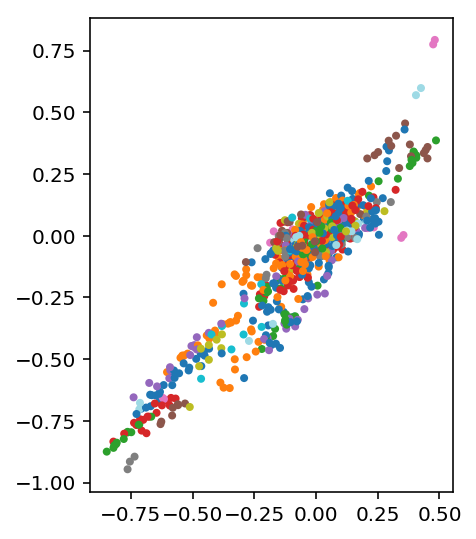

In [24]:
plt.scatter(Q1['A'].get_moments()[0].ravel(), Q2['A'].get_moments()[0].ravel(), c=np.repeat(labels, 10), cmap='tab20')
plt.gca().set_aspect(1)

array([ 0.18106346,  0.53437387])

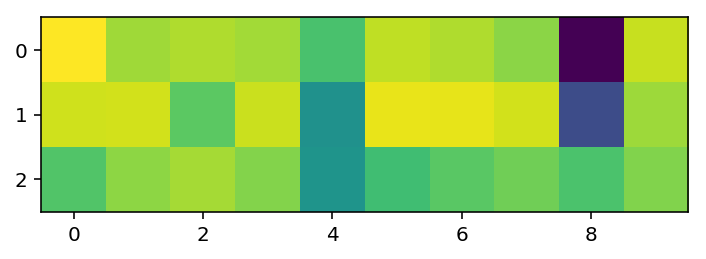

In [25]:
foo = []
for symbol in ['duk', 'exc', 'cost']:
    i = list(log_returns.columns).index(symbol)
    foo.append(_A[i])

plt.imshow(foo)
np.sum(np.diff(foo, axis=0) ** 2, axis=1)

In [26]:
with open('../data/metadata_sp100.json') as fp:
    metadata = json.load(fp)

In [27]:
delimiters = {
    (1, 3): 'Agriculture, foresting and fishing',
    (5, 9): 'Mining and quarrying',
    (10, 33): 'Manufacturing',
    (35, 39): 'Utilities',
    (41, 43): 'Construction',
    (45, 47): 'Wholesale and retail',
    (49, 53): 'Transportation and storage',
    (55, 56): 'Accommodation and food services',
    (58, 63): 'Information and communication',
    (64, 66): 'Financial and insurance',
    (68, 68): 'Real estate',
    (69, 75): 'Scientific and research',
    (77, 82): 'Administrative and support services',
    (84, 84): 'Public administration and defence',
    (85, 85): 'Education',
    (86, 88): 'Health and social work',
    (90, 93): 'Arts, entertainment and recreation',
    (94, 96): 'Other services',
    (97, 98): 'Domestic employment',
    (99, 99): 'Extraterritorial organisations'
}

isics = {key.lower(): value['isic'][0] for key, value in metadata.items()}
industries = {}

for key, isic in isics.items():
    industry = None
    for (l, u), name in delimiters.items():
        if l <= isic // 100 <= u:
            industry = name
    assert industry, (key, isic)
    industries[key] = industry

In [28]:
df = pd.DataFrame({
    'symbol': log_returns.columns, 
    'label': labels,
    'name': [names[symbol] for symbol in log_returns.columns],
    'industry': [industries[symbol] for symbol in log_returns.columns]
})

"""
for _, x in df.groupby('label'):
    print(json.dumps(list(zip(x.name, x.industry)), indent=4))
    print()
"""
pass

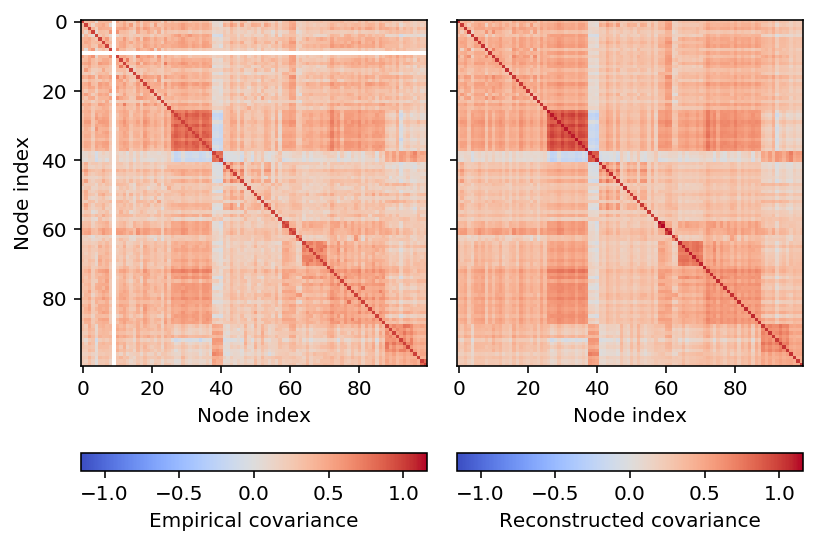

In [29]:
# Q = max(models2, key=lambda x: x.compute_lowerbound())
_A = Q['A'].get_moments()[0]
_z = Q['z'].get_moments()[0]
i = get_best_permutation(_A, _z)

fig, axes = plt.subplots(1, 2, True, True)

cov = np.cov(y.T)

reconstructed = np.dot(_A, _A.T)  + np.diag(1 / Q['tau'].get_moments()[0])

covs =[cov, reconstructed]
vmax = np.nanmax(np.abs(covs))

for ax, c, name in zip(axes, covs, ['Empirical covariance', 'Reconstructed covariance']):
    mappable = ax.imshow(c[i][:, i], vmin=-vmax, vmax=vmax, cmap='coolwarm')
    cb = plt.colorbar(mappable, ax=ax, orientation='horizontal')
    cb.set_label(name)
    ax.set_adjustable('box-forced')
    ax.set_xlabel('Node index')
axes[0].set_ylabel('Node index')

fig.tight_layout()
fig.savefig('sp100-covariance.png')
fig.savefig('sp100-covariance.pdf')

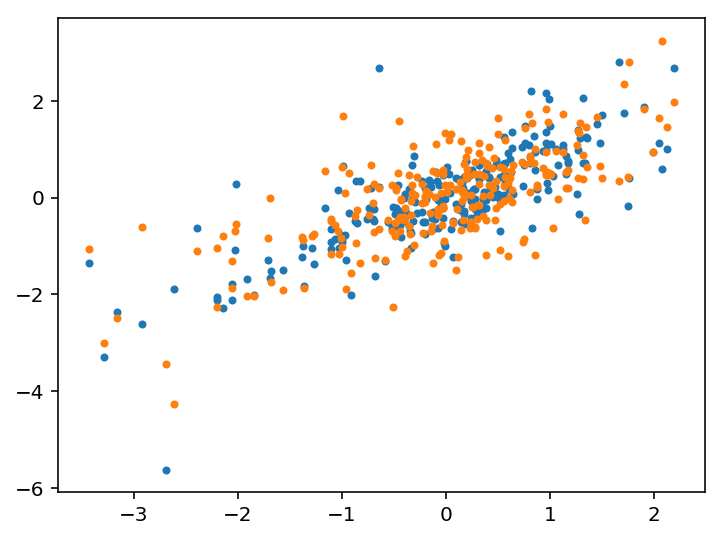

In [30]:
plt.scatter(nlr['duk'], nlr['nee'])
plt.scatter(nlr['duk'], nlr['exc'])

In [31]:
def plot_corr(a, b):
    x = nlr[a].values.astype(float)
    y = nlr[b].values.astype(float)
    plt.scatter(x, y)
    print(a, b, np.corrcoef(x, y)[0, 1])

exc mcd 0.219089181643
exc duk 0.692244273599


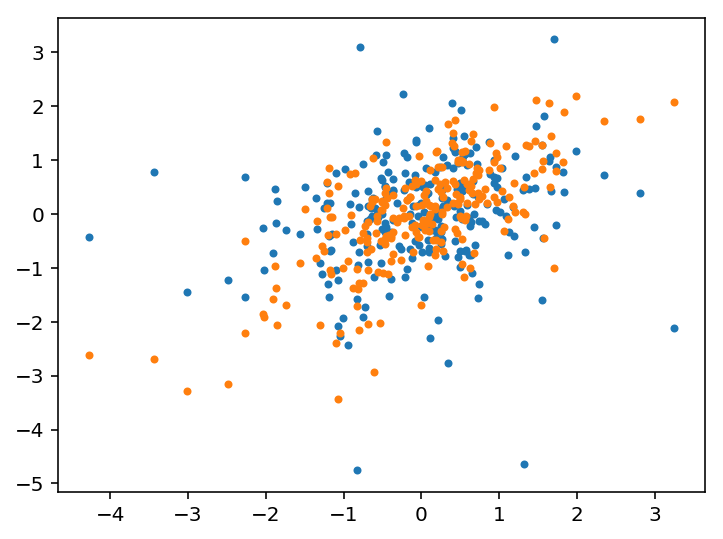

In [32]:
plot_corr('exc', 'mcd')
plot_corr('exc', 'duk')

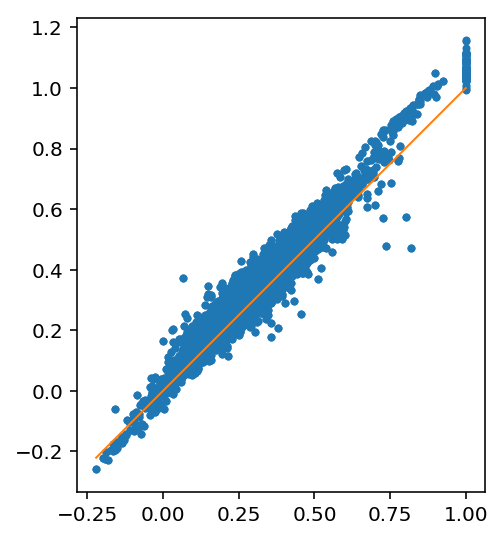

In [34]:
plt.scatter(cov.ravel(), reconstructed.ravel())
plt.gca().set_aspect(1)
mm = np.nanmin(cov), np.nanmax(cov)
plt.plot(mm, mm, color='C1')